In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [9]:
import glob
import os


In [10]:
# get all files under src/round1
files = glob.glob('src/round1/round-1-island-data-bottle/*')
files

['src/round1/round-1-island-data-bottle\\prices_round_1_day_-1.csv',
 'src/round1/round-1-island-data-bottle\\prices_round_1_day_-2.csv',
 'src/round1/round-1-island-data-bottle\\prices_round_1_day_0.csv',
 'src/round1/round-1-island-data-bottle\\trades_round_1_day_-1_nn.csv',
 'src/round1/round-1-island-data-bottle\\trades_round_1_day_-2_nn.csv',
 'src/round1/round-1-island-data-bottle\\trades_round_1_day_0_nn.csv']

In [11]:
prices = []
trades = []
for file in files:
    if 'prices' in file:
        prices.append(pd.read_csv(file,sep=';'))
    else:
        tmp = pd.read_csv(file,sep=';')
        tmp['day'] = int(os.path.basename(file).split('day_')[1].split('_')[0])
        tmp = tmp.loc[:,['day']+list(tmp.columns[:-1])]
        trades.append(tmp)
        
prices = pd.concat(prices).sort_values(['day','timestamp']).reset_index()
trades = pd.concat(trades).sort_values(['day','timestamp']).reset_index()

In [12]:
prices

,index,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss
0,0,-2,0,AMETHYSTS,9996,1,9995.0,25.0,NaN,NaN,10004,1,10005.0,25.0,NaN,NaN,10000.0,0.0
1,1,-2,0,STARFRUIT,4997,26,NaN,NaN,NaN,NaN,5003,26,NaN,NaN,NaN,NaN,5000.0,0.0
2,2,-2,100,AMETHYSTS,10000,5,9995.0,20.0,NaN,NaN,10005,20,NaN,NaN,NaN,NaN,10002.5,0.0
3,3,-2,100,STARFRUIT,5000,5,4998.0,6.0,4997.0,20.0,5004,20,NaN,NaN,NaN,NaN,5002.0,0.0
4,4,-2,200,STARFRUIT,4997,1,4996.0,30.0,NaN,NaN,5003,31,NaN,NaN,NaN,NaN,5000.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,19995,0,999700,STARFRUIT,5053,1,5048.0,26.0,NaN,NaN,5054,2,5055.0,24.0,NaN,NaN,5053.5,0.0
59996,19996,0,999800,STARFRUIT,5047,27,NaN,NaN,NaN,NaN,5052,1,5054.0,27.0,NaN,NaN,5049.5,0.0
59997,19997,0,999800,AMETHYSTS,9995,27,NaN,NaN,NaN,NaN,10005,27,NaN,NaN,NaN,NaN,10000.0,0.0
59998,19998,0,999900,STARFRUIT,5048,2,5047.0,21.0,NaN,NaN,5054,23,NaN,NaN,NaN,NaN,5051.0,0.0


In [13]:
trades

,index,day,timestamp,buyer,seller,symbol,currency,price,quantity
0,0,-2,0,NaN,NaN,AMETHYSTS,SEASHELLS,9996.0,1
1,1,-2,0,NaN,NaN,STARFRUIT,SEASHELLS,5003.0,1
2,2,-2,0,NaN,NaN,AMETHYSTS,SEASHELLS,9996.0,1
3,3,-2,100,NaN,NaN,STARFRUIT,SEASHELLS,5004.0,6
4,4,-2,900,NaN,NaN,STARFRUIT,SEASHELLS,5001.0,2
...,...,...,...,...,...,...,...,...,...
16145,5312,0,998800,NaN,NaN,STARFRUIT,SEASHELLS,5050.0,1
16146,5313,0,998800,NaN,NaN,AMETHYSTS,SEASHELLS,10002.0,1
16147,5314,0,999500,NaN,NaN,AMETHYSTS,SEASHELLS,9995.0,2
16148,5315,0,999500,NaN,NaN,STARFRUIT,SEASHELLS,5049.0,2


<Axes: ylabel='Frequency'>

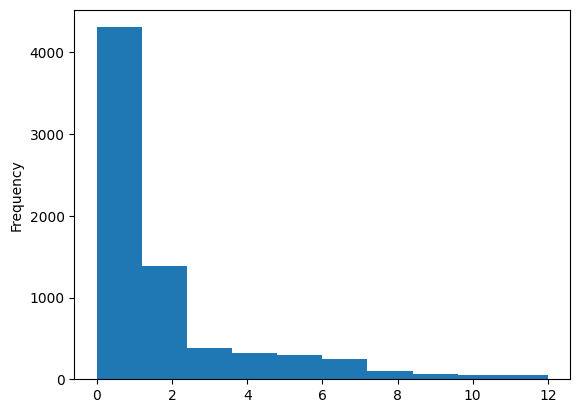

In [14]:
trades[trades['symbol']=='AMETHYSTS']['quantity'].plot(kind = 'hist')

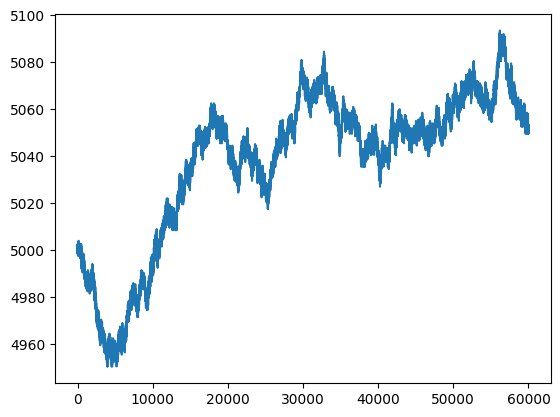

In [15]:
plt.plot(prices[prices['product']=='STARFRUIT']['mid_price'])

In [300]:
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import accuracy_score
from joblib import Parallel,delayed

In [333]:
periods = np.linspace(1,100,100)
def period_search(period):
    mid_price = prices[prices['product']=='STARFRUIT']['mid_price'].reset_index(drop=True)
    prediction_target = np.sign(mid_price.diff()).shift(-1).dropna()
    prediction_target[prediction_target==0] = np.nan
    prediction_target.bfill(inplace=True)
    result = seasonal_decompose(mid_price,model='m',two_sided=False,period=int(period))
    y_pred = ((result.trend*result.seasonal.shift(-1))-result.trend).dropna()
    return accuracy_score(prediction_target.iloc[y_pred.index],np.sign(y_pred))

In [334]:
search_res = Parallel(n_jobs=4)(delayed(period_search)(period) for period in periods)

(0.49, 0.55)

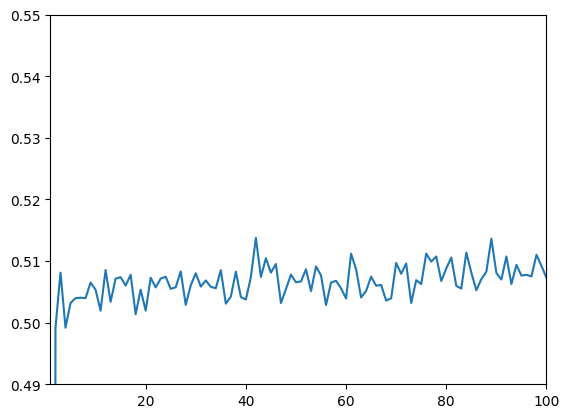

In [335]:
plt.plot(periods,search_res)
plt.xlim([1,100])
plt.ylim([0.49,0.55])

In [336]:
period = periods[np.argmax(search_res)]

In [337]:
period

42.0

In [321]:
results

[0.0,
 0.4991832516584992,
 0.5081174784145082,
 0.49918319719953325,
 0.5031838639773295,
 0.5039842629946988,
 0.5040509452205515,
 0.5039845286919409,
 0.5065186222533427,
 0.5053519623862083,
 0.5019507152622629,
 0.508553706606196,
 0.5033848000800347,
 0.5071535767883942,
 0.5073870268467567,
 0.5060200780442251,
 0.5077877463896208,
 0.5013842099996665,
 0.5053533904806378,
 0.5019513659561693,
 0.5072884352379999,
 0.5057210528071522,
 0.5071554858725023,
 0.5074562135112594,
 0.505487906588824,
 0.5057551796616955,
 0.508324158409235,
 0.5028861232524774,
 0.5060558539921924,
 0.5080249591244286,
 0.5058560512529614,
 0.5068575432976274,
 0.5058230720459171,
 0.5055898548306358,
 0.5085266143834474,
 0.5030871408069953,
 0.5042218736441612,
 0.5082941156837222,
 0.5041554020226294,
 0.5037551320137521,
 0.5073934376981876,
 0.5137697366224923,
 0.5074273124812231,
 0.5104656985478218,
 0.5081288599566016,
 0.5095315995058926,
 0.5031883283811305,
 0.5054589162298421,
 0.507796

[0.507274490785645]

In [290]:
(np.sign(y_pred))

100      1.0
101      1.0
102      1.0
103     -1.0
104      1.0
        ... 
29994    1.0
29995   -1.0
29996   -1.0
29997   -1.0
29998    1.0
Length: 29899, dtype: float64

-0.0040241666275440124

In [237]:
from sklearn.metrics import r2_score,mean_absolute_error
r2_score(mid_price.iloc[y_pred.index+1],np.round(y_pred))

0.9971069888761782

In [238]:
mean_absolute_error(mid_price.iloc[y_pred.index+1],np.round(y_pred))

1.2898763292109736

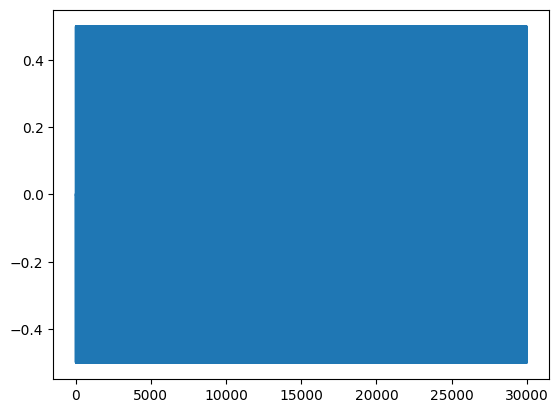

In [239]:
plt.plot(mid_price.iloc[y_pred.index+1]-np.round(y_pred))

In [240]:
mid_price.iloc[y_pred.index+1]-np.round(y_pred)

0        NaN
1        0.0
2        0.0
3       -0.5
4        0.5
        ... 
29995    0.5
29996    0.0
29997   -0.5
29998   -0.5
29999    NaN
Length: 30000, dtype: float64

In [241]:
result.trend

0        5000.0
1        5002.0
2        5000.0
3        4999.5
4        4998.5
          ...  
29995    5052.5
29996    5051.0
29997    5053.5
29998    5049.5
29999    5051.0
Name: trend, Length: 30000, dtype: float64

In [243]:
y_pred

0        5000.0
1        5002.0
2        5000.0
3        4999.5
4        4998.5
          ...  
29994    5051.5
29995    5052.5
29996    5051.0
29997    5053.5
29998    5049.5
Length: 29999, dtype: float64

In [242]:
y_true

0        5000.0
1        5002.0
2        5000.0
3        4999.5
4        4998.5
          ...  
29994    5051.5
29995    5052.5
29996    5051.0
29997    5053.5
29998    5049.5
Name: mid_price, Length: 29999, dtype: float64